## Aufgabe
- Pipeline erstellen
    + `CountVectorizer`
    + Naive Bayes
- es soll BernoulliNB genutzt werden
- Kreuzvalidierung für optimale Werte beim `CountVectorizer`
- zu Beachten: Train- und Testfehler für Precision oder Recall
    + Begründete entscheidung für eine dieser Metriken


### Begriffe

#### Pipeline
Ermöglciht einfacheres, sequenzielles ausführen von mehreren Schritten (z.B. Transformationen & Modelltraining)
-> saubererer Code

##### Beispiel:
```Python
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    # Schritte einfügen ...
])
```

#### CountVectorizer
Wandelt Texte in numerische Vektoren um, indem er zählt, wie oft Wörter im Text vorkommen.

#### BernoulliNB
- ist ein Naive Bayes Klassifikator für **binäre Features**
- `CountVectorizer(binary=True)` ermöglicht das Nutzen von BernoulliNB, da dann nur gecheckt wird, ob das Wort vorkommt oder nicht und nicht die Gesamtanzahl der Vorkommnisse

#### Kreuzvalidierung (Cross-Validation)
- Datensatz wird n Mal gesplittet und dann wird mit n-1 splits trainiert und dann an dem einen übrigen split getestet.
- Es können verschiedene Scores getestet werden (z.B.: Accuracy, Precision, Recall, etc. ...)
- siehe: `student_week2_wine.ipynb`

#### Erläuterung: "zu beachten: Train- und Testfehler für Precision oder Recall"
- bei der Kreuzvalidierung soll mit den Precision und Recall Metriken getestet werden
- dann soll eine der zwei Metriken mit Begründung gewählt werden

#### Scoring: 'precision' vs 'recall'
Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

Wenn eher Wert darauf gelegt wird, dass es möglichst wenige FP (False Positives) gibt, sollte man 'precision' nutzen. Umso besser der Score ist, umso weniger negative Einträge wurden als Positiv vorhergesagt (Spam als nicht-Spam eingeordnet)

Wenn eher Wert darauf gelegt wird, dass es möglichst wenige FN (False Negatives) gibt, sollte man 'recall' nutzen. Umso besser der Score ist, umso weniger positive Einträge wurden als Negativ vorhergesagt (nicht-Spam als Spam eingeordnet)

## Code

### Imports

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score

### Data

In [25]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/AiDevNepal/ai-saturdays-workshop-8/master/data/spam.csv'
)
data

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [26]:
data['target'].value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

### Training

In [27]:
countVectorizer = CountVectorizer(
    binary=True,
    stop_words='english',
    min_df=0.0025,
    max_df=0.90
)

In [28]:
pipeline = Pipeline([
    ('vectorizer', countVectorizer),
    ('classifier', BernoulliNB()),
])

In [29]:
# Eigene "scorer" um nicht spam und ham in 1 und 0 übersetzen zu müssen
precision_scorer = make_scorer(precision_score, pos_label="spam")
recall_scorer = make_scorer(recall_score, pos_label="spam")

In [30]:
# Anzahl an Splits:
splits = 20

# Dataframe shuffeln, damit nicht nur statische scores rauskommen
shuffle = True # True | False
randomState = None # None | Int

if shuffle:
    if randomState is None:
        data = data.sample(frac=1).reset_index(drop=True)
    else:
        data = data.sample(frac=1, random_state=randomState).reset_index(drop=True)

data

,text,target
0,Sorry that was my uncle. I.ll keep in touch,ham
1,Back in brum! Thanks for putting us up and kee...,ham
2,Allo! We have braved the buses and taken on th...,ham
3,I dont want to hear anything,ham
4,Shall i come to get pickle,ham
...,...,...
5567,\Its Ur luck to Love someone. Its Ur fortune t...,ham
5568,Turns out my friends are staying for the whole...,ham
5569,"I'll text carlos and let you know, hang on",ham
5570,I'm reaching home in 5 min.,ham


In [31]:
scoresPrecision = cross_val_score(pipeline, data['text'], data['target'], cv=splits, scoring=precision_scorer)
scoresPrecision

array([1.        , 1.        , 0.97058824, 1.        , 0.96875   ,
       1.        , 0.95      , 0.96428571, 1.        , 0.97058824,
       1.        , 1.        , 0.97058824, 1.        , 0.97368421,
       0.96774194, 0.94285714, 0.97058824, 0.97058824, 0.97222222])

In [32]:
scoresRecall = cross_val_score(pipeline, data['text'], data['target'], cv=splits, scoring=recall_scorer)
scoresRecall

array([0.89189189, 0.94594595, 0.89189189, 0.83783784, 0.83783784,
       0.94736842, 1.        , 0.71052632, 0.78947368, 0.86842105,
       0.81578947, 0.89473684, 0.89189189, 0.81081081, 1.        ,
       0.81081081, 0.89189189, 0.89189189, 0.89189189, 0.94594595])

### Evaluation

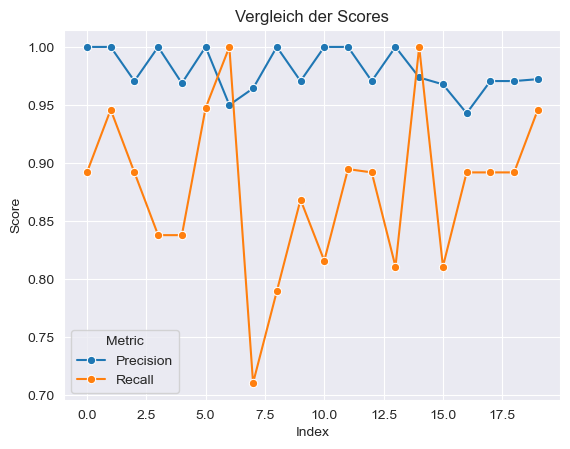

In [33]:
# Scores in Dataframe umwandeln
scores_df = pd.DataFrame({
    'Index': list(range(splits)),
    'Precision': scoresPrecision,
    'Recall': scoresRecall
})

# Dataframe in long Format bringen - sonst können nicht Precision & Recall gleichzeitig dargestellt werden...
scores_melted = scores_df.melt(id_vars='Index', var_name='Metric', value_name='Score')

plot = sns.lineplot(data=scores_melted, x='Index', y='Score', hue='Metric', marker='o')

plot.set_title("Vergleich der Scores")
plt.xlabel('Index')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [34]:
float(stat.mean(scoresRecall))


0.8783428165007112

In [35]:
float(stat.mean(scoresPrecision))

0.9796241200922927

Um ein Spamerkennungsmodel gut zu bewerten, würde ich 'recall' nutzen, da es in meinen Augen kritischer ist, wenn potentiell wichtige E-Mails als Spam eingeordnet werden, als Spam, der mal nicht korrekt als Spam erkannt wurde (was in diesem fall durch den 'precision'-Score gezeigt werden würde).

Notes:

recall = nicht-spam wird wird als spam erkannt ($\frac{TP}{TP+FP}$)

precision = spam wird nicht als spam erkannt ($\frac{TP}{TP+FN}$)